# Enhanced Baseline GAN

Imports & Setup

In [ ]:
import os
import glob
import numpy as np
from PIL import Image

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.models import inception_v3, Inception_V3_Weights

In [ ]:
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import time

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/GAN/ferritic_steel"
save_dir = "/content/drive/MyDrive/GAN/outputs/enhanced_dcgan_single_img"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(os.path.join(save_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)

Parameters

In [ ]:
image_size = 128        # 128x128 for Colab speed (you can try 256 if you have time & memory)
nz = 128                # latent dim
ngf = 64
ndf = 64
nc = 1                  # grayscale
batch_size = 16         # lower for Colab GPU stability
num_workers = 0         # 0 in Colab is safest; set 2-4 if you have faster I/O
epochs = 60             # change to desired
lrG = 2e-4
lrD = 1e-4
beta1 = 0.0
beta2 = 0.999
real_label_smooth = 0.9
fake_label = 0.0
fid_validation_freq = 5  # run FID every 5 epochs (less often on Colab saves time)
fid_sample_size = 64

DataLoader with Augmentation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.12, contrast=0.12),
    transforms.RandomAffine(degrees=8, translate=(0.08, 0.08), scale=(0.95, 1.05)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

In [ ]:
class SteelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(root_dir, "*")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, 0

In [ ]:
dataset = SteelDataset(data_path, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, pin_memory=(device.type=='cuda'))

In [ ]:
def check_dataset_images(dataset_path):
    files = glob.glob(dataset_path + "/*")
    bad_files = []
    for f in files:
        try:
            img = Image.open(f)
            img.verify()
        except Exception as e:
            bad_files.append((f, str(e)))
    if len(bad_files) > 0:
        print("Bad dataset images found:")
        for bf in bad_files:
            print(bf[0], " Error:", bf[1])
    else:
        print("All dataset images are valid.")
check_dataset_images(data_path)

All dataset images are valid.


SelfAttention Model

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query(x).view(B, -1, H*W).permute(0, 2, 1)  # B x N x C'
        proj_key = self.key(x).view(B, -1, H*W)                       # B x C' x N
        energy = torch.bmm(proj_query, proj_key)                      # B x N x N
        attention = self.softmax(energy)
        proj_value = self.value(x).view(B, -1, H*W)                   # B x C x N
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(B, C, H, W)
        out = self.gamma * out + x
        return out

def sn(layer):  # spectral norm wrapper
    return nn.utils.spectral_norm(layer)

Generator (outputs image_size x image_size)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, ngf=64, nc=1, out_size=128):
        super().__init__()
        # We'll make layers to upsample from 4x4 to out_size (e.g., 128)
        # 4 -> 8 -> 16 -> 32 -> 64 -> 128 : 6 steps (first conv gives 4)
        self.main = nn.Sequential(
            sn(nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False)),  # 4x4
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            sn(nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)),  # 8x8
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            SelfAttention(ngf * 8),

            sn(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),  # 16x16
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            sn(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),  # 32x32
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            sn(nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)),      # 64x64
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            SelfAttention(ngf),

            sn(nn.ConvTranspose2d(ngf, ngf // 2, 4, 2, 1, bias=False)),     # 128x128
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),

            sn(nn.ConvTranspose2d(ngf // 2, nc, 3, 1, 1, bias=False)),      # keep size
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super().__init__()
        # Input size 128 -> down to 4x4 conv then linear via conv to single map
        self.main = nn.Sequential(
            sn(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),  # 64x64
            nn.LeakyReLU(0.2, inplace=True),

            sn(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),  # 32x32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            sn(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),  # 16x16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(ndf * 4),

            sn(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),  # 8x8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            sn(nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)),  # 4x4
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            sn(nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)),  # 1x1
            # NO sigmoid
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.main(x)
        x = self.avgpool(x)
        x = x.view(x.size(0))  # flatten to (batch,)
        return x  # raw logits

Instantiate models, optimizers

In [ ]:
netG = Generator(nz=nz, ngf=ngf, nc=nc, out_size=image_size).to(device)
netD = Discriminator(nc=nc, ndf=ndf).to(device)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.995)
schedulerD = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.995)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

FID / SSIM utilities

In [ ]:
weights = Inception_V3_Weights.DEFAULT
inception_model = inception_v3(weights=weights, transform_input=False).to(device)
# Replace final fc with identity to get pooled features (2048-d)
inception_model.fc = nn.Identity()
inception_model.eval()
for p in inception_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 131MB/s] 


In [ ]:
def preprocess_for_fid(images):
    # images in [-1,1], shape (B,1,H,W) -> convert to (B,3,299,299) in [0,1]
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)
    images = (images + 1.0) / 2.0  # [-1,1] -> [0,1]
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    return images.to(device).float()

In [ ]:
def calculate_fid(real_images, fake_images, inception_model, eps=1e-6):
    inception_model.eval()
    real = preprocess_for_fid(real_images)
    fake = preprocess_for_fid(fake_images)

    with torch.no_grad():
        real_feats = inception_model(real).cpu().numpy()
        fake_feats = inception_model(fake).cpu().numpy()

    mu_r = np.mean(real_feats, axis=0)
    mu_f = np.mean(fake_feats, axis=0)
    sigma_r = np.cov(real_feats, rowvar=False)
    sigma_f = np.cov(fake_feats, rowvar=False)

    # numeric regularization
    sigma_r += np.eye(sigma_r.shape[0]) * eps
    sigma_f += np.eye(sigma_f.shape[0]) * eps

    diff = mu_r - mu_f
    covmean = sqrtm(sigma_r.dot(sigma_f))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_r + sigma_f - 2 * covmean)
    return float(np.real(fid))

In [ ]:
def calculate_ssim(real_images, fake_images):
    # real_images / fake_images: tensors normalized [-1,1] shape (B,1,H,W)
    real_np = real_images.squeeze(1).cpu().numpy()
    fake_np = fake_images.squeeze(1).cpu().numpy()
    ssim_scores = []
    for r, f in zip(real_np, fake_np):
        r_img = np.clip((r + 1.0)/2.0, 0.0, 1.0).astype(np.float32)
        f_img = np.clip((f + 1.0)/2.0, 0.0, 1.0).astype(np.float32)
        if r_img.shape != f_img.shape:
            # resize f_img to r_img if small mismatch
            continue
        try:
            score = ssim(r_img, f_img, data_range=1.0)
            ssim_scores.append(score)
        except Exception:
            continue
    return float(np.mean(ssim_scores)) if ssim_scores else 0.0

In [ ]:
def grain_size_constraint(generated):
    # generated: tensor [-1,1], shape (B, C, H, W)
    device_local = generated.device
    sobel_x_kernel = torch.tensor([[[[-1., 0., 1.],
                                     [-2., 0., 2.],
                                     [-1., 0., 1.]]]], device=device_local)
    sobel_y_kernel = torch.tensor([[[[-1., -2., -1.],
                                     [ 0.,  0.,  0.],
                                     [ 1.,  2.,  1.]]]], device=device_local)
    # if channels >1, apply to first
    if generated.shape[1] > 1:
        gen = generated[:, 0:1, :, :]
    else:
        gen = generated
    # scale to [0,1]
    gen = (gen + 1.0) / 2.0
    sobel_x = F.conv2d(gen, sobel_x_kernel, padding=1)
    sobel_y = F.conv2d(gen, sobel_y_kernel, padding=1)
    grad = torch.sqrt(sobel_x**2 + sobel_y**2 + 1e-8)
    avg_grad = grad.mean()
    min_g, max_g = 0.05, 0.3  # loosened bounds for stability
    if avg_grad < min_g:
        return (min_g - avg_grad) ** 2
    elif avg_grad > max_g:
        return (avg_grad - max_g) ** 2
    else:
        return torch.tensor(0., device=device_local)

In [ ]:
real_label_val = real_label_smooth
fake_label_val = fake_label

Training loop with validation & checkpoints

In [ ]:
print("Starting training...")
start_time = time.time()
best_fid = float("inf")

try:
    for epoch in range(1, epochs + 1):
        netG.train()
        netD.train()
        running_g_loss = 0.0
        running_d_loss = 0.0
        t0 = time.time()

        for i, (data, _) in enumerate(dataloader):
            real_data = data.to(device)
            b_size = real_data.size(0)

            # ----- Train Discriminator -----
            netD.zero_grad()
            label_real = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
            label_fake = torch.full((b_size,), fake_label_val, dtype=torch.float, device=device)

            output_real = netD(real_data)
            errD_real = criterion(output_real, label_real)
            errD_real.backward()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise)
            output_fake = netD(fake_data.detach())
            errD_fake = criterion(output_fake, label_fake)
            errD_fake.backward()

            optimizerD.step()
            d_loss = errD_real.item() + errD_fake.item()
            running_d_loss += d_loss

            # ----- Train Generator -----
            netG.zero_grad()
            label_gen = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
            output_for_g = netD(fake_data)
            errG_adv = criterion(output_for_g, label_gen)

            penalty = grain_size_constraint(fake_data)
            errG = errG_adv + 0.08 * penalty
            errG.backward()
            optimizerG.step()
            running_g_loss += errG.item()

            if i % 100 == 0:
                penalty_val = penalty.item() if isinstance(penalty, torch.Tensor) else float(penalty)
                print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(dataloader)}] "
                      f"D_loss: {d_loss:.4f} | G_loss: {errG.item():.4f} | Penalty: {penalty_val:.6f}")

        schedulerG.step()
        schedulerD.step()
        epoch_time = time.time() - t0
        print(f"Epoch {epoch} finished in {epoch_time:.1f}s | Avg D loss: {running_d_loss/len(dataloader):.4f} | Avg G loss: {running_g_loss/len(dataloader):.4f}")

        # ----- Validation / FID-SSIM -----
        if epoch % fid_validation_freq == 0 or epoch == 1:
            netG.eval()
            with torch.no_grad():
                real_samples_list = []
                for rb, _ in dataloader:
                    real_samples_list.append(rb)
                    if len(real_samples_list) * batch_size >= 100:
                        break
                real_samples = torch.cat(real_samples_list, 0)[:100].to(device)

                noise = torch.randn(100, nz, 1, 1, device=device)
                fake_samples = netG(noise)

                if real_samples.shape[-2:] != fake_samples.shape[-2:]:
                    fake_samples = F.interpolate(fake_samples, size=real_samples.shape[-2:], mode='bilinear', align_corners=False)

                fid_score = calculate_fid(real_samples, fake_samples, inception_model)
                ssim_score = calculate_ssim(real_samples, fake_samples)

                print(f"Validation @ Epoch {epoch}: FID = {fid_score:.2f}, SSIM = {ssim_score:.4f}")

                #  Save generated patches (robust)
                patch_save_dir = os.path.join(save_dir, "images", f"epoch_{epoch}_patches")
                os.makedirs(patch_save_dir, exist_ok=True)

                num_to_save = min(fake_samples.size(0), fid_sample_size)
                fake_cpu = fake_samples.detach().cpu()

                for j in range(num_to_save):
                    utils.save_image(fake_cpu[j],
                                     os.path.join(patch_save_dir, f"fake_{epoch}_{j+1}.png"),
                                     normalize=True)
                print(f"Saved {num_to_save} synthetic patches to {patch_save_dir}")

                #  Save best checkpoint
                if fid_score < best_fid:
                    best_fid = fid_score
                    torch.save({
                        'epoch': epoch,
                        'netG_state_dict': netG.state_dict(),
                        'netD_state_dict': netD.state_dict(),
                        'optimizerG_state_dict': optimizerG.state_dict(),
                        'optimizerD_state_dict': optimizerD.state_dict(),
                        'fid': fid_score,
                    }, os.path.join(save_dir, "checkpoints", f"best_checkpoint_epoch_{epoch}_fid_{fid_score:.2f}.pth"))
                    print(f" Saved new best checkpoint (FID {fid_score:.2f})")

                del real_samples, fake_samples, real_samples_list
                torch.cuda.empty_cache()

        # Save periodic checkpoint
        if epoch % 10 == 0:
            torch.save({
                'epoch': epoch,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
            }, os.path.join(save_dir, "checkpoints", f"ckpt_epoch_{epoch}.pth"))

except Exception as ex:
    print(" Training interrupted with exception:", ex)
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'error': str(ex),
    }, os.path.join(save_dir, "checkpoints", f"crash_epoch_{epoch}.pth"))
    raise

total_time = time.time() - start_time
print(f" Training complete. Total time: {total_time/60:.2f} minutes. Best FID: {best_fid:.2f}")

Starting training...
Epoch [1/60] Batch [0/106] D_loss: 1.6168 | G_loss: 11.0885 | Penalty: 0.382441
Epoch [1/60] Batch [100/106] D_loss: 1.6596 | G_loss: 2.8332 | Penalty: 0.107054
Epoch 1 finished in 53.0s | Avg D loss: 1.9209 | Avg G loss: 7.9950
Validation @ Epoch 1: FID = 325.14, SSIM = 0.0469
Saved 64 synthetic patches to /content/drive/MyDrive/GAN/outputs/enhanced_dcgan_single_img/images/epoch_1_patches
✅ Saved new best checkpoint (FID 325.14)
Epoch [2/60] Batch [0/106] D_loss: 1.1824 | G_loss: 3.1551 | Penalty: 0.033467
Epoch [2/60] Batch [100/106] D_loss: 1.8109 | G_loss: 0.5151 | Penalty: 0.023600
Epoch 2 finished in 52.1s | Avg D loss: 1.3239 | Avg G loss: 2.1656
Epoch [3/60] Batch [0/106] D_loss: 1.8180 | G_loss: 0.6591 | Penalty: 0.022767
Epoch [3/60] Batch [100/106] D_loss: 1.3032 | G_loss: 1.4995 | Penalty: 0.032085
Epoch 3 finished in 50.7s | Avg D loss: 1.4804 | Avg G loss: 1.3953
Epoch [4/60] Batch [0/106] D_loss: 1.2076 | G_loss: 1.8789 | Penalty: 0.054827
Epoch [4/6

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

resume training from epoch 61 → 120

In [ ]:
# reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"  # alternative: "expandable_segments:True"

# Load checkpoint (keep your existing path)
ckpt_path = "/content/drive/MyDrive/GAN/outputs/enhanced_dcgan_single_img/checkpoints/best_checkpoint_epoch_60.pth"
print("Loading checkpoint:", ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
start_epoch = checkpoint['epoch'] + 1
best_fid = checkpoint.get('fid', float("inf"))
print(f"Resumed from epoch {start_epoch}, Best FID so far: {best_fid:.2f}")

# memory housekeeping
gc.collect()
torch.cuda.empty_cache()

# Training params (safe defaults)
epochs = 120
fid_validation_freq = 5
fid_sample_size = 32
fid_chunk = 8
print("Starting training...")
start_time = time.time()

# helper: generate N fake samples in small batches (returns tensor on device)
def generate_fake_samples(netG, N, nz, chunk=fid_chunk, device=device):
    netG.eval()
    out_list = []
    with torch.no_grad():
        generated = 0
        while generated < N:
            cur = min(chunk, N - generated)
            noise = torch.randn(cur, nz, 1, 1, device=device)
            fake_chunk = netG(noise)
            out_list.append(fake_chunk.detach().cpu())  # move to CPU to free GPU memory
            generated += cur
    # concatenate on CPU, then move to device only if needed by FID function
    return torch.cat(out_list, dim=0)

try:
    for epoch in range(start_epoch, epochs + 1):
        netG.train(); netD.train()
        running_g_loss = 0.0; running_d_loss = 0.0
        t0 = time.time()

        for i, (data, _) in enumerate(dataloader):
            real_data = data.to(device, non_blocking=True)
            b_size = real_data.size(0)

            # --- Discriminator ---
            netD.zero_grad()
            label_real = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
            label_fake = torch.full((b_size,), fake_label_val, dtype=torch.float, device=device)

            output_real = netD(real_data)
            errD_real = criterion(output_real, label_real)

            noise = torch.randn(b_size, nz, 1, 1, device=device)   # use b_size (was fixed 16)
            fake_data = netG(noise)
            output_fake = netD(fake_data.detach())
            errD_fake = criterion(output_fake, label_fake)

            d_loss = errD_real + errD_fake
            d_loss.backward()
            optimizerD.step()

            # --- Generator ---
            netG.zero_grad()
            output_for_g = netD(fake_data)
            errG_adv = criterion(output_for_g, label_real)

            penalty = grain_size_constraint(fake_data)
            errG = errG_adv + 0.08 * penalty
            errG.backward()
            optimizerG.step()

            running_d_loss += d_loss.item()
            running_g_loss += errG.item()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] Batch {i}/{len(dataloader)} | D_loss: {d_loss.item():.4f} | G_loss: {errG.item():.4f} | Penalty: {penalty.item():.4f}")
                # free cached memory briefly
                torch.cuda.empty_cache()

        epoch_time = time.time() - t0
        print(f"Epoch {epoch} done in {epoch_time:.1f}s | Avg D: {running_d_loss/len(dataloader):.4f} | Avg G: {running_g_loss/len(dataloader):.4f}")

        # --- Validation: FID + SSIM (memory-safe) ---
        if epoch % fid_validation_freq == 0 or epoch == 1:
            # gather real samples (on CPU first)
            real_list = []
            real_needed = min(100, len(dataset))  # don't request more than dataset
            for rb, _ in dataloader:
                real_list.append(rb)
                if len(real_list) * batch_size >= real_needed:
                    break
            if len(real_list) == 0:
                print("Warning: no real samples for validation.")
                fid_score = float("inf")
                ssim_score = 0.0
            else:
                real_samples_cpu = torch.cat(real_list, 0)[:real_needed]  # CPU tensor
                fake_cpu = generate_fake_samples(netG, real_needed, nz, chunk=fid_chunk, device=device)  # CPU
                # prepare tensors for FID: move to device and preprocess
                real_for_fid = preprocess_for_fid(real_samples_cpu.to(device))
                fake_for_fid = preprocess_for_fid(fake_cpu.to(device))
                # compute FID & SSIM (inception_model is on device)
                fid_score = calculate_fid(real_for_fid, fake_for_fid, inception_model)
                # function expects device tensors
                with torch.no_grad():
                    real_ssim = (real_samples_cpu[:fid_sample_size].cpu().numpy() + 1)/2.0
                    fake_ssim = (fake_cpu[:fid_sample_size].cpu().numpy() + 1)/2.0
                # compute SSIM per image (keep it simple)
                from skimage.metrics import structural_similarity as ssim
                ssim_scores = []
                for r_img, f_img in zip(real_ssim, fake_ssim):
                    r = np.squeeze(r_img)
                    f = np.squeeze(f_img)
                    try:
                        ssim_scores.append(ssim(r, f, data_range=1.0))
                    except Exception:
                        continue
                ssim_score = float(np.mean(ssim_scores)) if ssim_scores else 0.0

                print(f"Validation @ Epoch {epoch}: FID = {fid_score:.2f}, SSIM = {ssim_score:.4f}")

                # save generated patches (from fake_cpu) individually (limit to fid_sample_size)
                patch_save_dir = os.path.join(save_dir, "images", f"epoch_{epoch}_patches")
                os.makedirs(patch_save_dir, exist_ok=True)
                num_to_save = min(fake_cpu.size(0), fid_sample_size)
                for j in range(num_to_save):
                    utils.save_image(fake_cpu[j], os.path.join(patch_save_dir, f"fake_{epoch}_{j+1}.png"), normalize=True)
                print(f"Saved {num_to_save} synthetic patches to {patch_save_dir}")

                # save best checkpoint if improved
                if fid_score < best_fid:
                    best_fid = fid_score
                    torch.save({
                        'epoch': epoch,
                        'netG_state_dict': netG.state_dict(),
                        'netD_state_dict': netD.state_dict(),
                        'optimizerG_state_dict': optimizerG.state_dict(),
                        'optimizerD_state_dict': optimizerD.state_dict(),
                        'fid': fid_score,
                    }, os.path.join(save_dir, "checkpoints", f"best_checkpoint_epoch_{epoch}_fid_{fid_score:.2f}.pth"))
                    print(f"New best checkpoint saved (FID {fid_score:.2f})")

                # free
                del real_samples_cpu, fake_cpu, real_list
                gc.collect()
                torch.cuda.empty_cache()

        # periodic checkpointing
        if epoch % 10 == 0:
            torch.save({
                'epoch': epoch,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'fid': best_fid
            }, os.path.join(save_dir, "checkpoints", f"resume_ckpt_epoch_{epoch}.pth"))
            print(f"Checkpoint saved at epoch {epoch}")

except Exception as e:
    print("Training crashed at epoch", epoch, ":", e)
    # save crash checkpoint
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'error': str(e),
    }, os.path.join(save_dir, "checkpoints", f"crash_epoch_{epoch}.pth"))
    raise

total_time = (time.time() - start_time) / 60
print(f"Training finished. Time (min): {total_time:.1f}. Best FID: {best_fid:.2f}")


Loading checkpoint: /content/drive/MyDrive/GAN/outputs/enhanced_dcgan_single_img/checkpoints/best_checkpoint_epoch_75_fid_92.85.pth
Resumed from epoch 76, Best FID so far: 92.85
Starting training...
[Epoch 76/120] Batch 0/106 | D_loss: 0.6399 | G_loss: 2.5738 | Penalty: 0.0799
[Epoch 76/120] Batch 50/106 | D_loss: 0.5830 | G_loss: 4.1947 | Penalty: 0.0942
[Epoch 76/120] Batch 100/106 | D_loss: 0.6780 | G_loss: 4.6740 | Penalty: 0.0872
Epoch 76 done in 50.0s | Avg D: 0.7661 | Avg G: 3.7226
[Epoch 77/120] Batch 0/106 | D_loss: 0.5752 | G_loss: 3.7494 | Penalty: 0.0910
[Epoch 77/120] Batch 50/106 | D_loss: 0.5585 | G_loss: 3.0698 | Penalty: 0.1223
[Epoch 77/120] Batch 100/106 | D_loss: 1.1664 | G_loss: 1.8130 | Penalty: 0.0770
Epoch 77 done in 50.1s | Avg D: 0.7644 | Avg G: 3.5605
[Epoch 78/120] Batch 0/106 | D_loss: 0.8242 | G_loss: 2.5996 | Penalty: 0.1044
[Epoch 78/120] Batch 50/106 | D_loss: 0.6035 | G_loss: 2.3252 | Penalty: 0.1463
[Epoch 78/120] Batch 100/106 | D_loss: 0.9668 | G_lo

In [ ]:
torch.save({
    'epoch': epoch,
    'netG_state_dict': netG.state_dict(),
    'netD_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
}, os.path.join(save_dir, "checkpoints", f"final_checkpoint.pth"))

In [ ]:
checkpoint_path = "/content/drive/MyDrive/GAN/outputs/enhanced_dcgan_single_img/checkpoints/final_checkpoint.pth"

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [ ]:
netG.load_state_dict(checkpoint["netG_state_dict"])
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): SelfAttention(
      (query): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (7): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), p

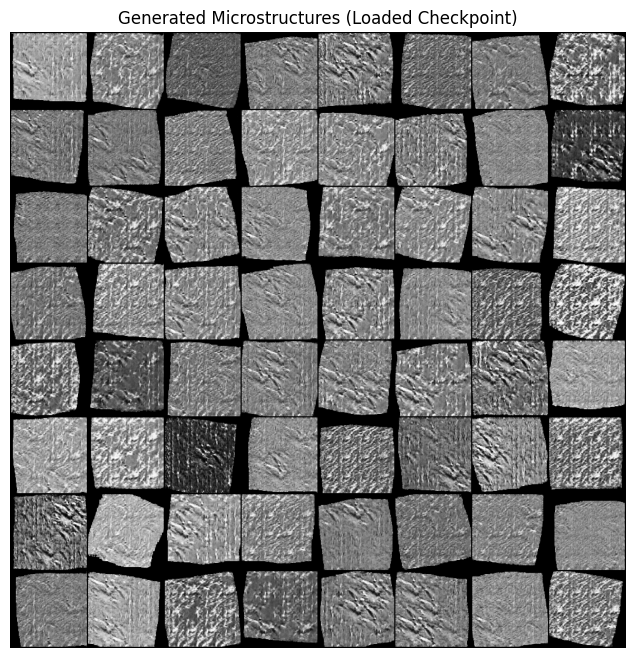

In [ ]:
import torchvision.utils as vutils
# Generate noise and produce synthetic images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fake_images = netG(fixed_noise).detach().cpu()

# Visualize the output grid
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Microstructures (Loaded Checkpoint)")
plt.imshow(
    np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0))
)
plt.show()

## Phase 1: Visual Comparison

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

In [ ]:
real_dir = "/content/drive/MyDrive/GAN/ferritic_steel"
fake_dir = "/content/drive/MyDrive/GAN/outputs/enhanced_dcgan_single_img/images/epoch_120_patches"

In [ ]:
def load_images_from_folder(folder, n=64):
    files = os.listdir(folder)
    n = min(n, len(files))
    files = random.sample(files, n)
    imgs = [Image.open(os.path.join(folder, f)).convert("L") for f in files]
    return imgs

In [ ]:
def plot_grid(images, title, ncols=8):
    nrows = len(images)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(10,10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
real_imgs = load_images_from_folder(real_dir)
fake_imgs = load_images_from_folder(fake_dir)

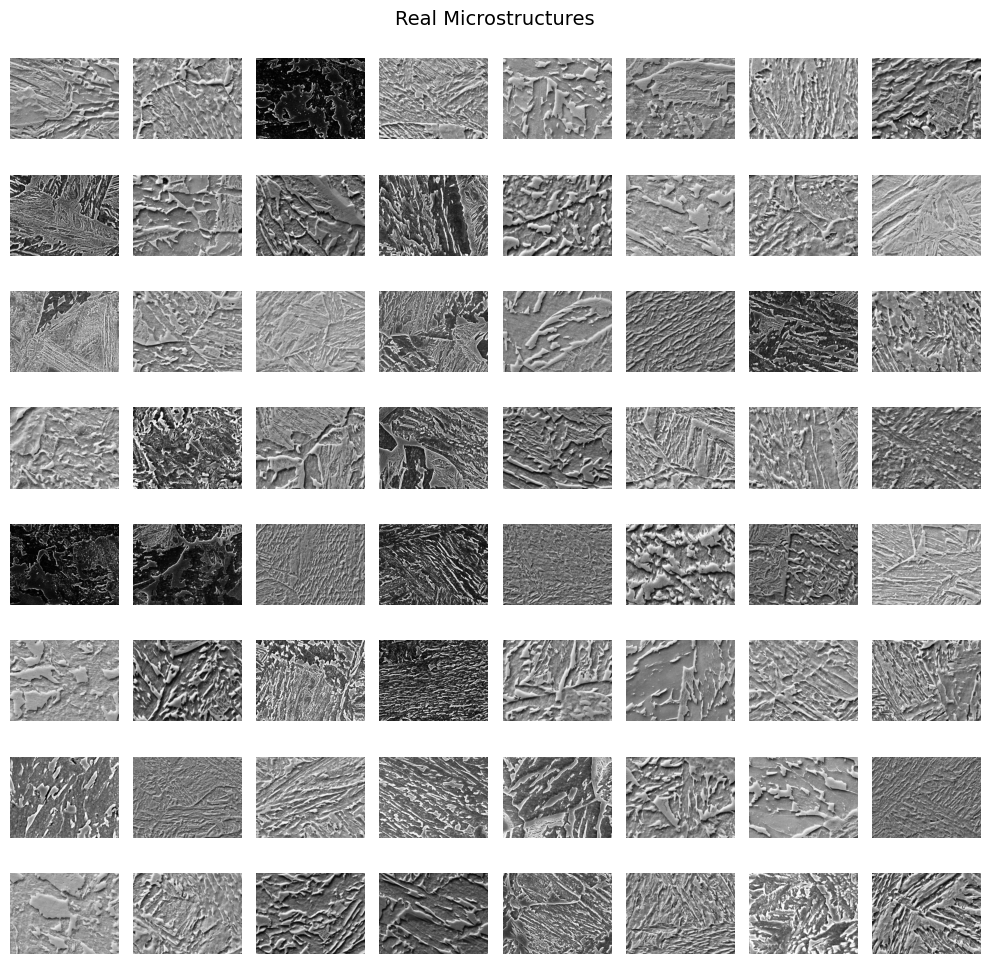

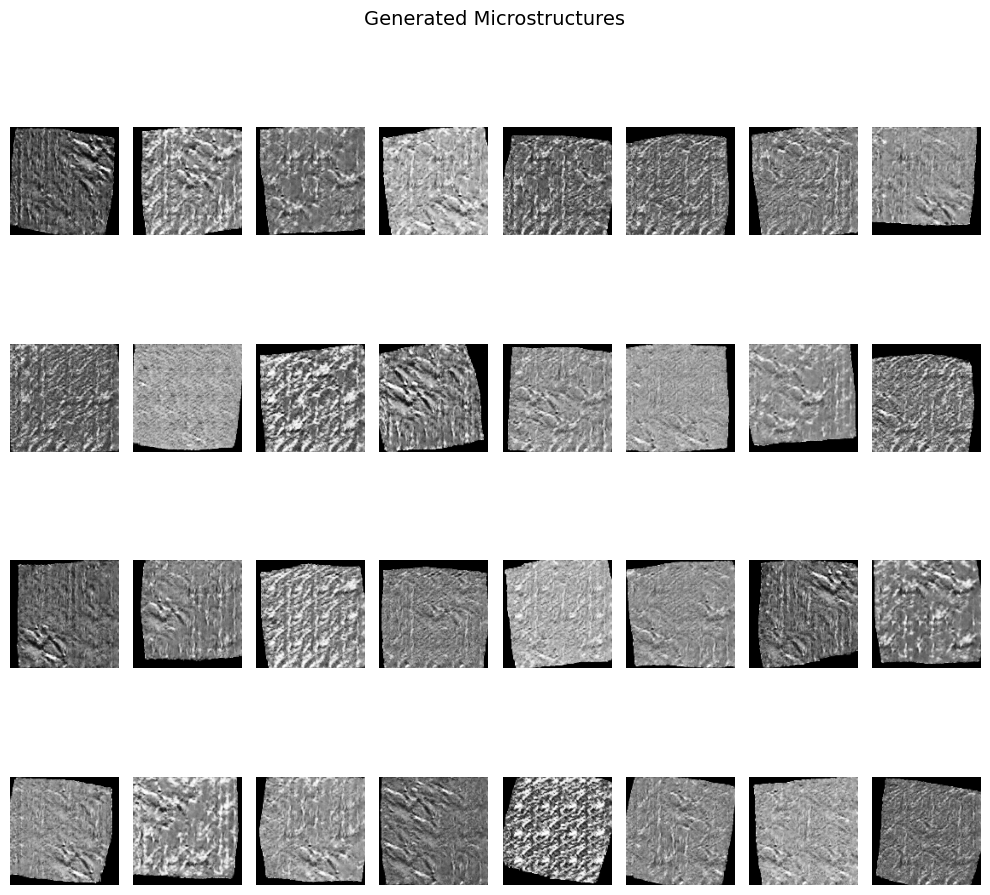

In [ ]:
plot_grid(real_imgs, "Real Microstructures")
plot_grid(fake_imgs, "Generated Microstructures")


## Phase 2: Statistical Comparison

In [ ]:
import numpy as np

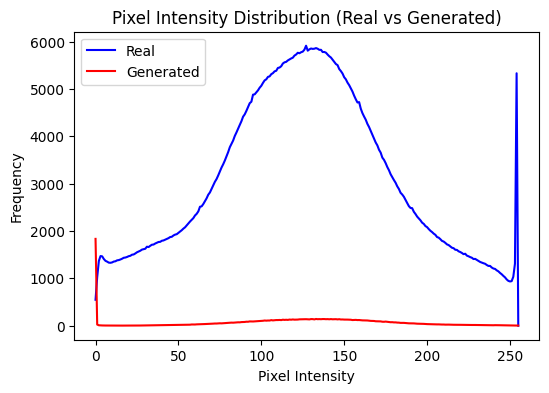

In [ ]:
def compute_intensity_hist(images):
    hist_sum = np.zeros(256)
    for img in images:
        arr = np.array(img)
        hist, _ = np.histogram(arr, bins=256, range=(0,255))
        hist_sum += hist
    return hist_sum / len(images)

real_hist = compute_intensity_hist(real_imgs)
fake_hist = compute_intensity_hist(fake_imgs)

plt.figure(figsize=(6,4))
plt.plot(real_hist, label="Real", color='blue')
plt.plot(fake_hist, label="Generated", color='red')
plt.legend()
plt.title("Pixel Intensity Distribution (Real vs Generated)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim

ssim_scores = []
for i in range(20):
    r = np.array(real_imgs[i].resize((64,64)))
    f = np.array(fake_imgs[i].resize((64,64)))
    s = ssim(r, f)
    ssim_scores.append(s)

print(f"Average SSIM between Real & Generated: {np.mean(ssim_scores):.4f}")


Average SSIM between Real & Generated: 0.0382


Feature-based comparison

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
inception.fc = nn.Identity()
inception.eval().to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
def get_features(folder, n=None):
    imgs = os.listdir(folder)
    if n: imgs = imgs[:n]
    features = []

    for img_name in tqdm(imgs, desc=f"Extracting from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = inception(img_t).squeeze().cpu().numpy()
        features.append(feat)
    return np.array(features)

In [ ]:
real_features = get_features(real_dir, n=100)
fake_features = get_features(fake_dir, n=100)

Extracting from epoch_120_patches: 100%|██████████| 32/32 [00:00<00:00, 53.49it/s]


In [ ]:
real_features

array([[0.6924908 , 0.15517628, 0.3431602 , ..., 0.4076817 , 0.6357218 ,
        1.3461552 ],
       [0.5334763 , 0.48365447, 0.12395461, ..., 0.80392796, 0.5988824 ,
        0.46679837],
       [0.10927226, 0.15784739, 0.00725596, ..., 0.96125054, 0.269866  ,
        0.42042047],
       ...,
       [0.50564396, 0.24177727, 0.09022693, ..., 0.23853868, 0.26390815,
        1.3175516 ],
       [0.20938498, 0.17867598, 0.14566138, ..., 0.3501699 , 0.23193076,
        1.1113033 ],
       [0.4419701 , 0.15574189, 0.12589782, ..., 0.10605607, 0.42607647,
        0.6204282 ]], dtype=float32)

In [ ]:
fake_features

array([[5.4389238e-01, 9.7686239e-02, 4.6646435e-02, ..., 8.8322127e-01,
        4.2376205e-01, 7.1430492e-01],
       [3.0486488e-01, 1.0164209e-01, 9.4650880e-02, ..., 4.4989178e-01,
        1.1606582e-01, 2.0946275e-02],
       [7.3810118e-01, 3.9735723e-01, 1.1052381e-01, ..., 7.4080539e-01,
        1.9264908e-01, 1.8607342e-01],
       ...,
       [3.7259853e-01, 4.4805042e-02, 6.6108390e-04, ..., 1.1558592e+00,
        5.7303570e-02, 3.3775544e-01],
       [2.9175675e-01, 4.2302713e-01, 6.2998399e-02, ..., 9.2756844e-01,
        7.2100297e-02, 1.8881623e-01],
       [1.3036872e-01, 2.3452382e-01, 6.7758471e-02, ..., 7.9527396e-01,
        6.5336788e-01, 2.7262247e-01]], dtype=float32)

Quantitative Comparison (FID / Mean–Covariance Distance)

In [ ]:
from scipy import linalg

In [ ]:
def calculate_fid_from_features(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

In [ ]:
mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

In [ ]:
fid_feature = calculate_fid_from_features(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"Feature-space FID: {fid_feature:.2f}")

/tmp/ipython-input-1434408818.py:3: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


Feature-space FID: 300.74


t-SNE Visualization

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
all_features = np.concatenate([real_features, fake_features], axis=0)
labels = np.array([0]*len(real_features) + [1]*len(fake_features))  # 0=real, 1=fake

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
emb2d = tsne.fit_transform(all_features)

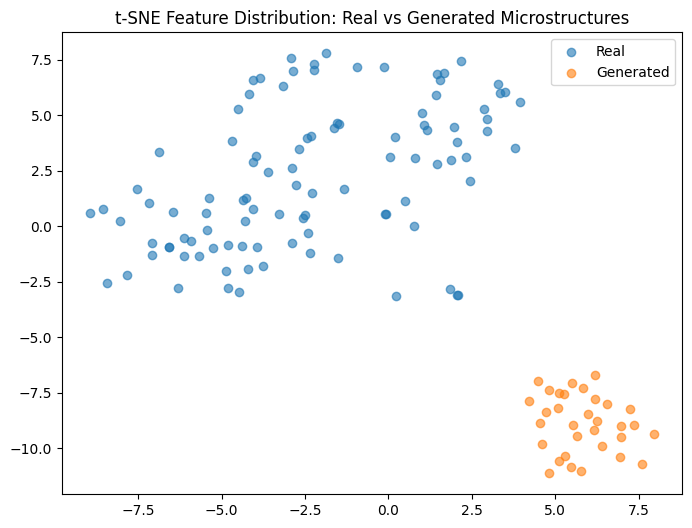

In [ ]:
# Plot
plt.figure(figsize=(8,6))
plt.scatter(emb2d[labels==0, 0], emb2d[labels==0, 1], label='Real', alpha=0.6)
plt.scatter(emb2d[labels==1, 0], emb2d[labels==1, 1], label='Generated', alpha=0.6)
plt.title("t-SNE Feature Distribution: Real vs Generated Microstructures")
plt.legend()
plt.show()

Statistical Feature Comparison

In [ ]:
import numpy as np
from skimage import io, measure
from scipy.stats import skew, kurtosis
import glob, cv2, os

In [ ]:
def get_stat_features(folder, n=100):
    paths = glob.glob(os.path.join(folder, "*.png"))[:n]
    stats = []
    for p in paths:
        img = io.imread(p, as_gray=True)
        vals = img.flatten()
        hist = np.histogram(vals, bins=50, range=(0,1))[0]
        hist = hist / np.sum(hist)
        entropy = measure.shannon_entropy(img)
        stats.append([
            np.mean(vals),
            np.std(vals),
            skew(vals),
            kurtosis(vals),
            entropy
        ])
    stats = np.array(stats)
    return np.mean(stats, axis=0), np.std(stats, axis=0)

In [ ]:
real_mean, real_std = get_stat_features(real_dir)
fake_mean, fake_std = get_stat_features(fake_dir)
print("Real stats mean:", real_mean)
print("Fake stats mean:", fake_mean)

Real stats mean: [0.5655841  0.1590027  0.54483442 0.12312245 7.12243455]
Fake stats mean: [ 0.46738358  0.21193871 -0.79428802  0.87847956  6.76742229]


Morphological Feature Comparison

In [ ]:
from skimage import measure, morphology, filters
import numpy as np

In [ ]:
def get_morphology_features(folder, n=50):
    paths = glob.glob(os.path.join(folder, "*.png"))[:n]
    morph = []
    for p in paths:
        img = io.imread(p, as_gray=True)
        # threshold for grain segmentation
        th = filters.threshold_otsu(img)
        binary = img > th
        binary = morphology.remove_small_objects(binary, 30)
        labeled = measure.label(binary)
        props = measure.regionprops(labeled)
        if len(props) == 0: continue
        areas = [r.area for r in props]
        perims = [r.perimeter for r in props]
        circ = [4*np.pi*a/(p**2 + 1e-6) for a,p in zip(areas,perims)]
        morph.append([
            np.mean(areas),
            np.std(areas),
            np.mean(circ),
            np.mean([r.eccentricity for r in props])
        ])
    morph = np.array(morph)
    return np.mean(morph, axis=0), np.std(morph, axis=0)

In [ ]:
real_morph_mean, real_morph_std = get_morphology_features(real_dir)
fake_morph_mean, fake_morph_std = get_morphology_features(fake_dir)
print("Real morphology:", real_morph_mean)
print("Fake morphology:", fake_morph_mean)

Real morphology: [1.07425107e+03 6.26165108e+03 4.14863312e-01 8.60821235e-01]
Fake morphology: [1.18879942e+04 2.10493661e+02 2.08356816e-01 3.44291024e-01]


Visualization & Reporting

In [ ]:
import matplotlib.pyplot as plt

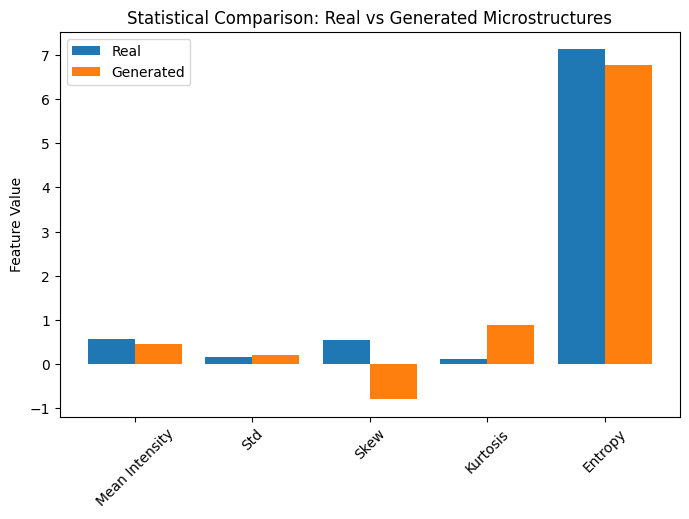

In [ ]:
labels = ["Mean Intensity", "Std", "Skew", "Kurtosis", "Entropy"]
x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x-0.2, real_mean, 0.4, label='Real')
plt.bar(x+0.2, fake_mean, 0.4, label='Generated')
plt.xticks(x, labels, rotation=45)
plt.ylabel("Feature Value")
plt.title("Statistical Comparison: Real vs Generated Microstructures")
plt.legend()
plt.show()